In [2]:
import os
import cv2
import numpy as np
import random

def get_png_filename_list(directory):
    return sorted([f for f in os.listdir(directory) if f.endswith('.png')])

class DataGen:
    def __init__(self, path, split_ratio, x, y, color_space='rgb'):
        self.x = x
        self.y = y
        self.path = path
        self.color_space = color_space
        self.path_train_images = os.path.join(path, "train/images/")
        self.path_train_labels = os.path.join(path, "train/labels/")

        # Obtén las listas de archivos
        self.image_file_list = get_png_filename_list(self.path_train_images)
        self.label_file_list = get_png_filename_list(self.path_train_labels)

        # Baraja ambas listas de forma sincronizada
        self.image_file_list, self.label_file_list = self.shuffle_image_label_lists_together()

        self.split_index = int(split_ratio * len(self.image_file_list))
        self.x_train_file_list = self.image_file_list[self.split_index:]
        self.y_train_file_list = self.label_file_list[self.split_index:]
        self.x_val_file_list = self.image_file_list[:self.split_index]
        self.y_val_file_list = self.label_file_list[:self.split_index]

    def shuffle_image_label_lists_together(self):
        combined = list(zip(self.image_file_list, self.label_file_list))
        random.shuffle(combined)
        image_file_list, label_file_list = zip(*combined)
        return list(image_file_list), list(label_file_list)

    def load_image(self, image_path):
        # Lee la imagen en el espacio de color especificado
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.x, self.y))
        return img / 255.0  # Normaliza la imagen entre 0 y 1

    def load_label(self, label_path):
        # Lee la etiqueta (máscara)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, (self.x, self.y))
        return label / 255.0  # Normaliza la etiqueta entre 0 y 1

    def generate_data(self, batch_size, train=False, val=False):
        while True:
            if train:
                x_file_list = self.x_train_file_list
                y_file_list = self.y_train_file_list
            elif val:
                x_file_list = self.x_val_file_list
                y_file_list = self.y_val_file_list

            for i in range(0, len(x_file_list), batch_size):
                x_batch = np.zeros((batch_size, self.x, self.y, 3))
                y_batch = np.zeros((batch_size, self.x, self.y, 1))

                for j in range(batch_size):
                    if (i + j) >= len(x_file_list):
                        break
                    x_batch[j] = self.load_image(os.path.join(self.path_train_images, x_file_list[i + j]))
                    y_batch[j] = np.expand_dims(self.load_label(os.path.join(self.path_train_labels, y_file_list[i + j])), axis=-1)

                yield x_batch, y_batch

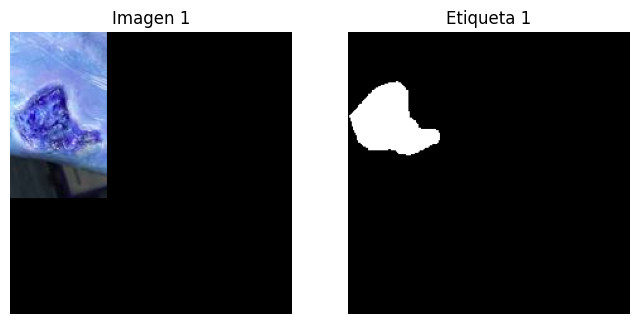

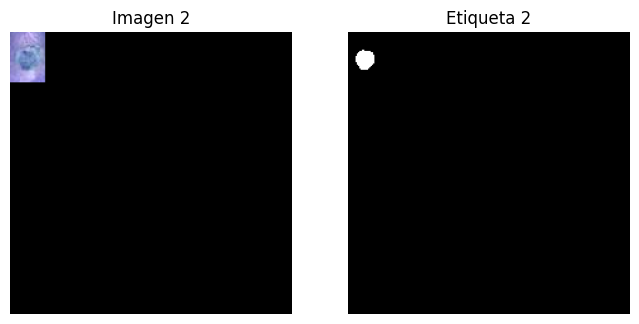

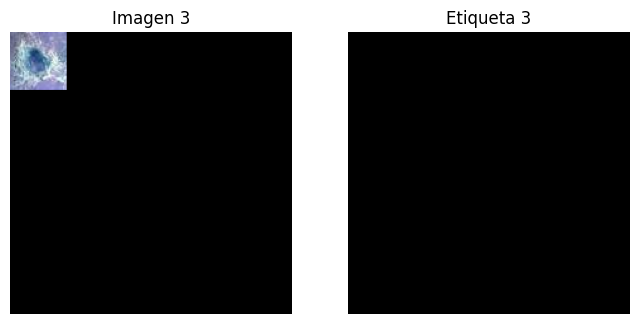

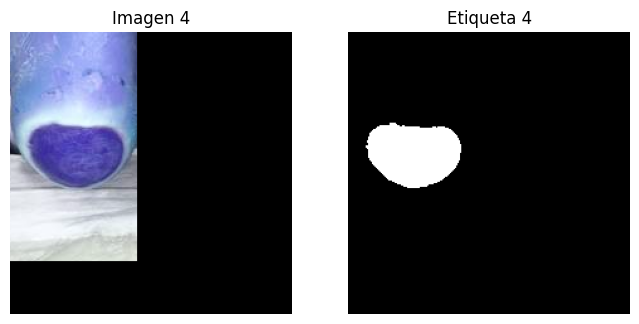

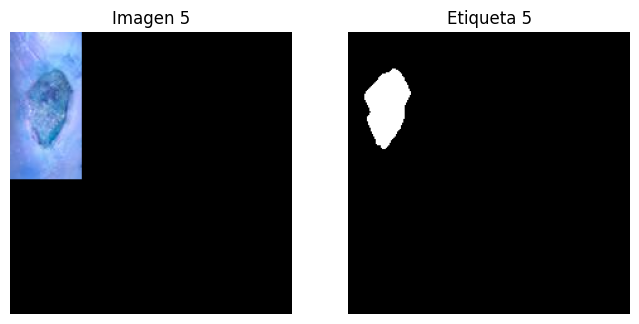

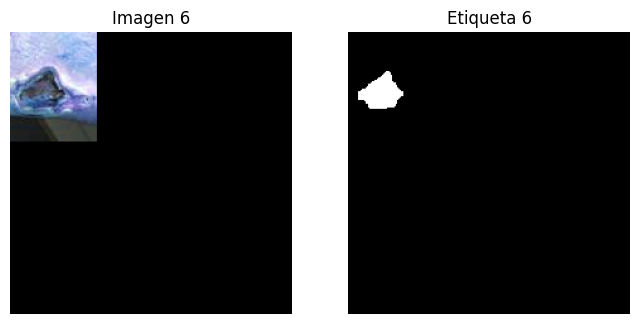

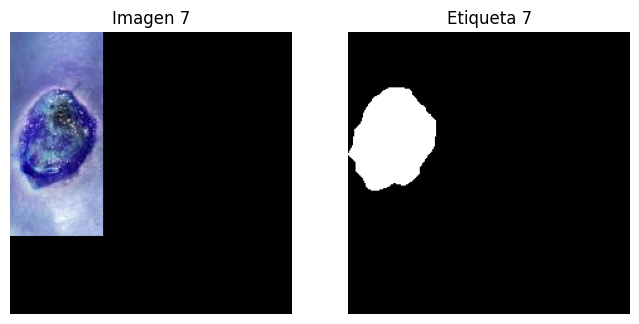

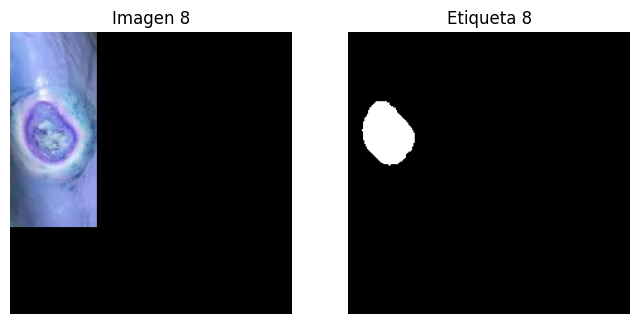

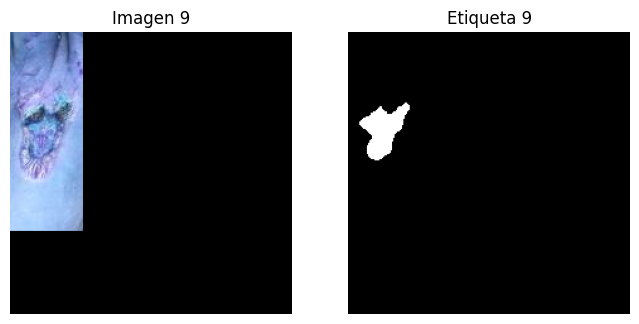

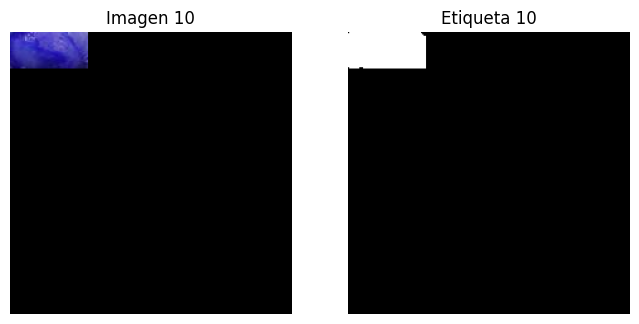

In [4]:
# Varibales and data generator
input_dim_x=224
input_dim_y=224
n_filters = 32
image_dir = 'Downloads/azh_wound'
data_gen = DataGen( image_dir + '/', split_ratio=0.2, x=input_dim_x, y=input_dim_y)
import matplotlib.pyplot as plt

# Generar un lote de datos de entrenamiento usando data_gen
image_batch, label_batch = next(data_gen.generate_data(batch_size=10, train=True))

# Mostrar las primeras 10 imágenes y etiquetas correspondientes
for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Desnormalizar la imagen (asumiendo que los valores estaban entre 0 y 1)
    image = image_batch[i] * 255  # Multiplicamos por 255 para revertir la normalización si es necesario
    image = image.astype('uint8')  # Convertir a uint8 para mostrar la imagen correctamente

    # Mostrar la imagen
    axes[0].imshow(image)
    axes[0].set_title(f"Imagen {i+1}")
    axes[0].axis('off')

    # Mostrar la etiqueta (máscara)
    axes[1].imshow(label_batch[i].squeeze(), cmap='gray')
    axes[1].set_title(f"Etiqueta {i+1}")
    axes[1].axis('off')

    plt.show()

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Input

class SegNet:
    def __init__(self, n_filters, input_dim_x, input_dim_y, num_channels):
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.n_filters = n_filters
        self.num_channels = num_channels

    def get_SegNet(self):
        # Input layer
        convnet_input = Input(shape=(self.input_dim_x, self.input_dim_y, self.num_channels))

        # Encoder path
        encoder_conv1 = Conv2D(self.n_filters, kernel_size=9, activation='relu', padding='same')(convnet_input)
        pool1 = MaxPooling2D(pool_size=(2, 2))(encoder_conv1)

        encoder_conv2 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(encoder_conv2)

        encoder_conv3 = Conv2D(self.n_filters * 2, kernel_size=5, activation='relu', padding='same')(pool2)
        pool3 = MaxPooling2D(pool_size=(2, 2))(encoder_conv3)

        encoder_conv4 = Conv2D(self.n_filters * 2, kernel_size=5, activation='relu', padding='same')(pool3)
        pool4 = MaxPooling2D(pool_size=(2, 2))(encoder_conv4)

        # Bottleneck layer
        conv5 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(pool4)

        # Decoder path
        decoder_conv6 = Conv2D(self.n_filters, kernel_size=7, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
        decoder_conv7 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(decoder_conv6))
        decoder_conv8 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(decoder_conv7))

        # Output layer with sigmoid activation for binary segmentation
        decoder_conv9 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(UpSampling2D(size=(2, 2))(decoder_conv8))

        # Create the model
        model = Model(inputs=convnet_input, outputs=decoder_conv9)

        return model, 'SegNet'

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Input

class SegNet:
    def __init__(self, n_filters, input_dim_x, input_dim_y, num_channels):
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.n_filters = n_filters
        self.num_channels = num_channels

    def get_SegNet(self):
        # Input layer
        convnet_input = Input(shape=(self.input_dim_x, self.input_dim_y, self.num_channels))

        # Encoder path
        encoder_conv1 = Conv2D(self.n_filters, kernel_size=9, activation='relu', padding='same')(convnet_input)
        pool1 = MaxPooling2D(pool_size=(2, 2))(encoder_conv1)

        encoder_conv2 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(encoder_conv2)

        encoder_conv3 = Conv2D(self.n_filters * 2, kernel_size=5, activation='relu', padding='same')(pool2)
        pool3 = MaxPooling2D(pool_size=(2, 2))(encoder_conv3)

        encoder_conv4 = Conv2D(self.n_filters * 2, kernel_size=5, activation='relu', padding='same')(pool3)
        pool4 = MaxPooling2D(pool_size=(2, 2))(encoder_conv4)

        # Bottleneck layer
        conv5 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(pool4)

        # Decoder path
        decoder_conv6 = Conv2D(self.n_filters, kernel_size=7, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
        decoder_conv7 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(decoder_conv6))
        decoder_conv8 = Conv2D(self.n_filters, kernel_size=5, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(decoder_conv7))

        # Output layer with sigmoid activation for binary segmentation
        decoder_conv9 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(UpSampling2D(size=(2, 2))(decoder_conv8))

        # Create the model
        model = Model(inputs=convnet_input, outputs=decoder_conv9)

        return model, 'SegNet'

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

# Definir las dimensiones de entrada
input_dim_x = 224
input_dim_y = 224
n_filters = 32
num_channels = 3  # RGB images


# Crear el modelo SegNet
segnet = SegNet(n_filters, input_dim_x, input_dim_y, num_channels)
model, model_name = segnet.get_SegNet()

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[MeanIoU(num_classes=2)])  # MeanIoU para evaluar segmentación binaria

# Resumen del modelo
model.summary()

# Generar datos para entrenamiento y validación
batch_size = 16  # Definir el tamaño del lote
train_gen = data_gen.generate_data(batch_size=batch_size, train=True)
val_gen = data_gen.generate_data(batch_size=batch_size, val=True)

# Definir el número de pasos por época y el número de épocas
steps_per_epoch = len(data_gen.x_train_file_list) // batch_size
validation_steps = len(data_gen.x_val_file_list) // batch_size
epochs = 200  # Número de épocas

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 32)        │           7,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 224, 224, 1)         │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 339,905 (1.30 MB)

 Trainable params: 339,905 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entrenar el modelo
history = model.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs)

# Guardar el modelo entrenado
model.save(f'{model_name}_trained.h5')

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - loss: 0.2814 - mean_io_u_1: 0.4866 - val_loss: 0.0586 - val_mean_io_u_1: 0.4877
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - loss: 0.0576 - mean_io_u_1: 0.4871 - val_loss: 0.0529 - val_mean_io_u_1: 0.4882
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - loss: 0.0540 - mean_io_u_1: 0.4873 - val_loss: 0.0478 - val_mean_io_u_1: 0.4882
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - loss: 0.0522 - mean_io_u_1: 0.4866 - val_loss: 0.0467 - val_mean_io_u_1: 0.4883
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - loss: 0.0477 - mean_io_u_1: 0.4870 - val_loss: 0.0412 - val_mean_io_u_1: 0.4890
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step - loss: 0.0421 - mean_io_u_1: 0.4874 - val_loss: 0.0418 - val_mean_io_u_1: 0.4881
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step - loss: 0.0410 - mean_io_u_1: 0.4868 - val_loss: 0.0392 - val_mean_io_u_1: 0.4882
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms